In [1]:
import pandas as pd 
import numpy as np
import numpy as np 
import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re
import nltk, string
from nltk.corpus import stopwords
from textblob import TextBlob, Word

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, vstack
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, f1_score

from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Embedding, SimpleRNN


#load stopwords corpus
import nltk
nltk.download('stopwords')
#load the en_core_web_sm 
import en_core_web_sm
nlp = en_core_web_sm.load()

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
CBS_NEWS=pd.read_csv(r"C:\Users\yuzhu\Documents\725_2semester\cbs_news_content.csv",header=None)
CBS_NEWS.columns=['link',"title","Author","timestamp","Paragraph_num","Paragraph_text","download_date"]

In [4]:
#create a stop words list
stopWordList = [word for word in list(stopwords.words('english') ) if word not in ['no', 'not']]
# all the data in this dataset is true news, then the target show all equal to 0
CBS_NEWS["target"]=0

In [5]:
# list of punctuation that need to be removed
punct_removal = list(string.punctuation) + ["--", "---"]
# define the the word pattern
word_pattern = r"(?u)\b\w\w+\b"

In [6]:
#check if NAN in columns
CBS_NEWS["Paragraph_text"].isnull().values.any()

#check how many of NAN in columns
CBS_NEWS["Paragraph_text"].isnull().sum()
# check how many NAN in the whole dataset
CBS_NEWS.isnull().values.sum()

# fill the NAN with whitespace
CBS_NEWS["Paragraph_text"]=CBS_NEWS["Paragraph_text"].fillna(" ")

In [7]:
%%time
tokened_para=[]
for i in range(len(CBS_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )

    CBS_NEWS["Paragraph_text"][i] = " ".join(word_pat.findall(CBS_NEWS["Paragraph_text"][i])).lower()
    
    tokens = nlp(CBS_NEWS["Paragraph_text"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_para.append(processed_text) 
    

C:\Users\yuzhu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Wall time: 4min


In [8]:
%%time
tokened_title=[]
for i in range(len(CBS_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )
    CBS_NEWS["title"][i] = " ".join(word_pat.findall(CBS_NEWS["title"][i])).lower()
    tokens = nlp(CBS_NEWS["title"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_title.append(processed_text) 

C:\Users\yuzhu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Wall time: 1min 26s


In [9]:
tokened_para_df=pd.DataFrame(tokened_para)
tokened_title_df=pd.DataFrame(tokened_title)
CBS_NEWS["tokened_para"]=tokened_para_df
CBS_NEWS["tokened_title"]=tokened_title_df
CBS_NEWS['all_text']=CBS_NEWS["tokened_title"]+CBS_NEWS["tokened_para"]

In [10]:
# CBS_NEWS[["tokened_title","tokened_para","target"]]
CBS_NEWS["tokened_para"]

0       run nearly week late northrop grumman antares ...
1       rocket russian build rd 181 first stage engine...
2       climb away southeast directly plane space stat...
3       launch come six day last minute abort last sun...
4       pad climb orbit go smoothly supply ship releas...
                              ...                        
9434          gadget still good people use even year 2062
9435    still many element jetson future people consta...
9436                        may get fly car yet say cowan
9437                                              exactly
9438                                                 info
Name: tokened_para, Length: 9439, dtype: object

In [11]:
PEPPER_NEWS=pd.read_csv(r"C:\Users\yuzhu\Documents\725_2semester\pepper_news_content.csv",header=None)

In [12]:
PEPPER_NEWS.columns=PEPPER_NEWS.loc[0,]
PEPPER_NEWS=PEPPER_NEWS.loc[1:,]

In [13]:
PEPPER_NEWS.columns

Index(['title', 'author', 'time_stamp', 'paragraph_num', 'paragragh'], dtype='object', name=0)

In [14]:
PEPPER_NEWS["Paragraph_text"]=PEPPER_NEWS[ 'paragragh'].fillna(" ")
PEPPER_NEWS["title"]=PEPPER_NEWS[ 'title'].fillna(" ")

In [15]:
%%time
tokened_para_p=[]
for i in range(1,len(PEPPER_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )

    PEPPER_NEWS["Paragraph_text"][i] = " ".join(word_pat.findall(PEPPER_NEWS["Paragraph_text"][i])).lower()
    
    tokens = nlp(PEPPER_NEWS["Paragraph_text"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_para_p.append(processed_text) 

Wall time: 15.1 s


In [16]:
%%time
tokened_title_p=[]
for i in range(1,len(PEPPER_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )
    PEPPER_NEWS["title"][i] = " ".join(word_pat.findall(PEPPER_NEWS["title"][i])).lower()
    tokens = nlp(PEPPER_NEWS["title"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_title_p.append(processed_text) 

Wall time: 10.2 s


In [17]:
tokened_para_p_df=pd.DataFrame(tokened_para_p)
tokened_title_p_df=pd.DataFrame(tokened_title_p)
PEPPER_NEWS["tokened_para"]=tokened_para_p_df
PEPPER_NEWS["tokened_title"]=tokened_title_p_df
PEPPER_NEWS['all_text']=PEPPER_NEWS["tokened_title"]+PEPPER_NEWS["tokened_para"]

In [18]:
PEPPER_NEWS['target']=1
PEPPER_NEWS=PEPPER_NEWS.rename(columns={"author":"Author"})
PEPPER_NEWS.columns

Index(['title', 'Author', 'time_stamp', 'paragraph_num', 'paragragh',
       'Paragraph_text', 'tokened_para', 'tokened_title', 'all_text',
       'target'],
      dtype='object', name=0)

In [19]:
CBS_NEWS=CBS_NEWS[['title', 'Author', 'tokened_para','tokened_title', 'all_text','target']]

In [20]:
PEPPER_NEWS=PEPPER_NEWS[['title', 'Author', 'tokened_para','tokened_title', 'all_text','target']]

In [23]:
NEWS_COMBINE=pd.concat([CBS_NEWS,PEPPER_NEWS],axis=0)
NEWS_COMBINE=NEWS_COMBINE.dropna(subset=['tokened_title', 'tokened_para'])

In [24]:
NEWS_COMBINE.shape

(10949, 6)

In [25]:
NEWS_COMBINE.groupby("target").count()

,title,Author,tokened_para,tokened_title,all_text
target,,,,,
0,9439,5954,9439,9439,9439
1,1510,1510,1510,1510,1510


In [26]:
NEWS_COMBINE["tokened_title"].isnull().sum()

0

In [27]:
NEWS_COMBINE.shape

(10949, 6)

In [28]:
%%time
vec = TfidfVectorizer(ngram_range=(1,3))
vec.fit(NEWS_COMBINE.all_text)
vocab = vec.vocabulary_
    
# vecH = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, vocabulary=vocab)
# vecH.fit(NEWS_COMBINE.tokened_title.unique())
    
vecB = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, vocabulary=vocab)
vecB.fit(NEWS_COMBINE.tokened_para.unique())
    
# xHTrainTfidf = vecH.transform(NEWS_COMBINE.tokened_title)
# print ('Train headline matrix shape: \t', xHTrainTfidf.shape)
    
xBTrainTfidf = vecB.transform(NEWS_COMBINE.tokened_para)
print('Train body matrix shape: \t', xBTrainTfidf.shape) 

Train body matrix shape: 	 (10949, 417398)
Wall time: 4.09 s


In [29]:
from keras.preprocessing.text import Tokenizer

In [164]:
# from keras.preprocessing.text import Tokenizer
# # We create a tokenizer, configured to only take
# # into account the top-1000 most common words
# tokenizer = Tokenizer()
# # This builds the word index
# tokenizer.fit_on_texts(NEWS_COMBINE['tokened_para'])

# # This turns strings into lists of integer indices.
# sequences = tokenizer.texts_to_sequences(NEWS_COMBINE['tokened_para'])

# # You could also directly get the one-hot binary representations.
# # Note that other vectorization modes than one-hot encoding are supported!
# one_hot_results = tokenizer.texts_to_matrix(NEWS_COMBINE['tokened_para'], mode='binary')

# # This is how you can recover the word index that was computed
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

Found 14920 unique tokens.


In [30]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# max_features = 10000  # number of words to consider as features
# maxlen = 500  # cut texts after this number of words (among top max_features most common words)
# batch_size = 32

# print('Loading data...')
# (input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(input_train), 'train sequences')
# print(len(input_test), 'test sequences')

# print('Pad sequences (samples x time)')
# input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
# input_test = sequence.pad_sequences(input_test, maxlen=maxlen)


In [31]:
from keras.layers import Embedding
from keras import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Embedding, SimpleRNN

X_train, X_test, y_train, y_test = train_test_split(NEWS_COMBINE["tokened_para"],NEWS_COMBINE.iloc[:,-1],test_size=0.33,random_state=42)
embedding_layer=Embedding(1000,64)


In [37]:
# from the Tfid the max_feature is xBTrainTfidf.shape
max_feature=xBTrainTfidf.shape[1]
# max_feature=10000
# select the top 500 in the sequence
maxlen=500

tk = Tokenizer()
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=maxlen)

In [151]:
# t = Tokenizer()
# t.fit_on_texts(X_train)
# # vocab_size = len(t.word_index) + 1
# vocab_size = 7335
# X_encoded_train = t.texts_to_sequences(X_train)
# X_encoded_train11 = preprocessing.sequence.pad_sequences(X_encoded_train, maxlen=maxlen, padding='post')

In [149]:
# embedding_matrix = zeros((vocab_size, 100))
# for word, i in t.word_index.items():
#     embedding_vector = word_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [130]:
model_Simple = Sequential()
model_Simple.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_Simple.add(SimpleRNN(32))
model_Simple.add(Dense(1, activation='sigmoid'))

model_Simple.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model_Simple.fit(X_train_seq_trunc, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

In [162]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of SimpleRNN')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of SimpleRNN')
plt.legend()

plt.show()

(7335, 500)

In [38]:
%%time
from keras import models
from keras import layers
model_Flatten = models.Sequential()
model_Flatten.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_Flatten.add(layers.Flatten())
model_Flatten.add(Dense(1, activation='sigmoid'))

model_Flatten.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model_Flatten.fit(X_train_seq_trunc, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5868 samples, validate on 1467 samples
Epoch 1/10
5868/5868 [==============================] - 3s 496us/step - loss: 0.4187 - acc: 0.8555 - val_loss: 0.3650 - val_acc: 0.8664
Epoch 2/10
5868/5868 [==============================] - 3s 452us/step - loss: 0.3507 - acc: 0.8560 - val_loss: 0.3043 - val_acc: 0.8664
Epoch 3/10
5868/5868 [==============================] - 3s 526us/step - loss: 0.2665 - acc: 0.8620 - val_loss: 0.2172 - val_acc: 0.8787
Epoch 4/10
5868/5868 [==============================] - 3s 506us/step - loss: 0.1793 - acc: 0.9271 - val_loss: 0.1411 - val_acc: 0.9577
Epoch 5/10
5868/5868 [==============================] - 3s 481us/step - loss: 0.1087 - acc: 0.9806 - val_loss: 0.0859 - val_acc: 0.9809
Epoch 6/10
5868/5868 [==============================] - 3s 498us/step - loss: 0.0634 - acc: 0.9923 - val_loss: 0.0520 - val_acc: 0.9932
Epoch 7/10
5868/5868 [==============================] - 3s 494us/step - loss: 0.0371 - acc: 0.9954 - val_loss: 0.0317 - val_acc: 1.0000


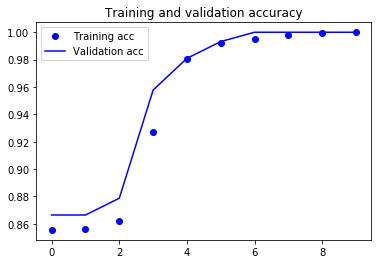

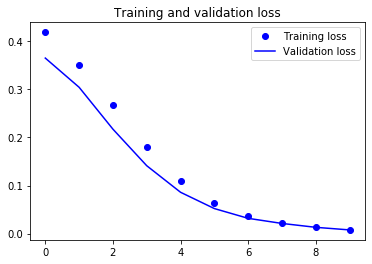

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Flatten')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Flatten')
plt.legend()

plt.show()

In [43]:
%%time
#optimizer is RMSprop
from keras.layers import LSTM
from keras import models
from keras import layers
model_LSTM = models.Sequential()
model_LSTM.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_LSTM.add(layers.LSTM(32))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model_LSTM.fit(X_train_seq_trunc, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5868 samples, validate on 1467 samples
Epoch 1/10
5868/5868 [==============================] - 21s 4ms/step - loss: 0.4308 - acc: 0.8492 - val_loss: 0.3266 - val_acc: 0.8664
Epoch 2/10
5868/5868 [==============================] - 22s 4ms/step - loss: 0.2103 - acc: 0.9160 - val_loss: 0.1090 - val_acc: 0.9768
Epoch 3/10
5868/5868 [==============================] - 23s 4ms/step - loss: 0.1175 - acc: 0.9804 - val_loss: 0.0599 - val_acc: 0.9898
Epoch 4/10
5868/5868 [==============================] - 23s 4ms/step - loss: 0.0665 - acc: 0.9916 - val_loss: 0.0374 - val_acc: 1.0000
Epoch 5/10
5868/5868 [==============================] - 22s 4ms/step - loss: 0.0318 - acc: 0.9968 - val_loss: 0.0842 - val_acc: 0.9591
Epoch 6/10
5868/5868 [==============================] - 24s 4ms/step - loss: 0.0223 - acc: 0.9973 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 7/10
5868/5868 [==============================] - 25s 4ms/step - loss: 0.0242 - acc: 0.9910 - val_loss: 0.0319 - val_acc: 0.9823
Epoch 8

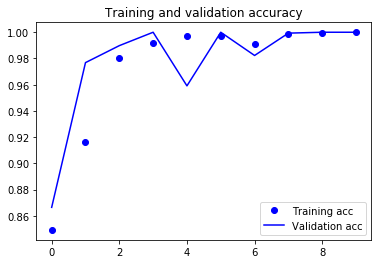

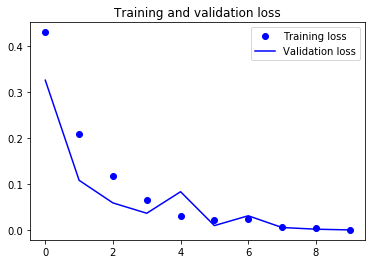

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of LSTM')
plt.legend()

plt.show()

In [45]:
%%time
#optimizer is Adam
from keras.layers import LSTM
from keras import models
from keras import layers
model_ADM_LSTM = models.Sequential()
model_ADM_LSTM.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_ADM_LSTM.add(layers.LSTM(32))
model_ADM_LSTM.add(Dense(1, activation='sigmoid'))

model_ADM_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model_ADM_LSTM.fit(X_train_seq_trunc, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5868 samples, validate on 1467 samples
Epoch 1/10
5868/5868 [==============================] - 24s 4ms/step - loss: 0.5133 - acc: 0.8504 - val_loss: 0.3762 - val_acc: 0.8664
Epoch 2/10
5868/5868 [==============================] - 24s 4ms/step - loss: 0.3052 - acc: 0.8666 - val_loss: 0.1475 - val_acc: 0.9864
Epoch 3/10
5868/5868 [==============================] - 24s 4ms/step - loss: 0.1287 - acc: 0.9993 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 4/10
5868/5868 [==============================] - 24s 4ms/step - loss: 0.0993 - acc: 0.9910 - val_loss: 0.1000 - val_acc: 0.9870
Epoch 5/10
5868/5868 [==============================] - 25s 4ms/step - loss: 0.0703 - acc: 0.9879 - val_loss: 0.0593 - val_acc: 0.9870
Epoch 6/10
5868/5868 [==============================] - 24s 4ms/step - loss: 0.0509 - acc: 0.9884 - val_loss: 0.0475 - val_acc: 0.9877
Epoch 7/10
5868/5868 [==============================] - 22s 4ms/step - loss: 0.0409 - acc: 0.9889 - val_loss: 0.0391 - val_acc: 0.9891
Epoch 8

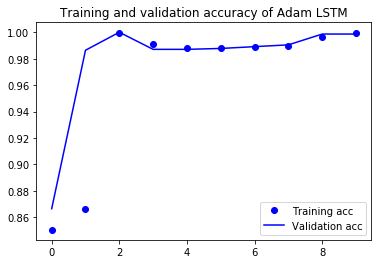

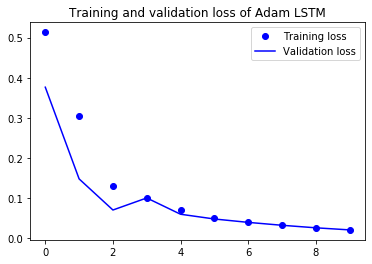

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Adam LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Adam LSTM')
plt.legend()

plt.show()

In [51]:
%%time
#optimizer is Adam
from keras.layers import LSTM
from keras import models
from keras import layers
model_BiD_LSTM = models.Sequential()
model_BiD_LSTM.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_BiD_LSTM.add(layers.Bidirectional(layers.LSTM(32)))
model_BiD_LSTM.add(Dense(1, activation='sigmoid'))

model_BiD_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model_BiD_LSTM.fit(X_train_seq_trunc, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5868 samples, validate on 1467 samples
Epoch 1/10
5868/5868 [==============================] - 78s 13ms/step - loss: 0.5015 - acc: 0.8405 - val_loss: 0.3642 - val_acc: 0.8664
Epoch 2/10
5868/5868 [==============================] - 168s 29ms/step - loss: 0.2880 - acc: 0.8897 - val_loss: 0.2378 - val_acc: 1.0000
Epoch 3/10
5868/5868 [==============================] - 92s 16ms/step - loss: 0.1586 - acc: 0.9957 - val_loss: 0.1132 - val_acc: 0.9993
Epoch 4/10
5868/5868 [==============================] - 89s 15ms/step - loss: 0.0970 - acc: 0.9927 - val_loss: 0.0821 - val_acc: 0.9898
Epoch 5/10
5868/5868 [==============================] - 91s 15ms/step - loss: 0.0708 - acc: 0.9925 - val_loss: 0.0598 - val_acc: 0.9966
Epoch 6/10
5868/5868 [==============================] - 90s 15ms/step - loss: 0.0665 - acc: 0.9963 - val_loss: 0.0419 - val_acc: 1.0000
Epoch 7/10
5868/5868 [==============================] - 91s 15ms/step - loss: 0.0333 - acc: 0.9998 - val_loss: 0.0279 - val_acc: 1.0000

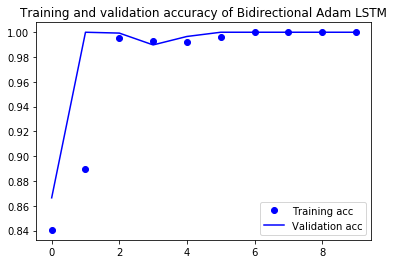

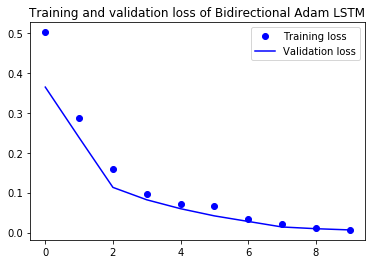

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Bidirectional Adam LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Bidirectional Adam LSTM')
plt.legend()

plt.show()